In [167]:
import reservoirpy.nodes as nodes
import reservoirpy as rpy
from reservoirpy.datasets import lorenz
import numpy as np
import matplotlib.pyplot as plt
rpy.set_seed(42)  
%matplotlib inline

In [168]:
X = lorenz(2000)

# Normalizing Series in the range of [-1,1]
X_min, X_max = X.min(), X.max()
X_norm_01 = (X - X_min) / (X_max - X_min)
X_norm_final = 2 * X_norm_01 - 1

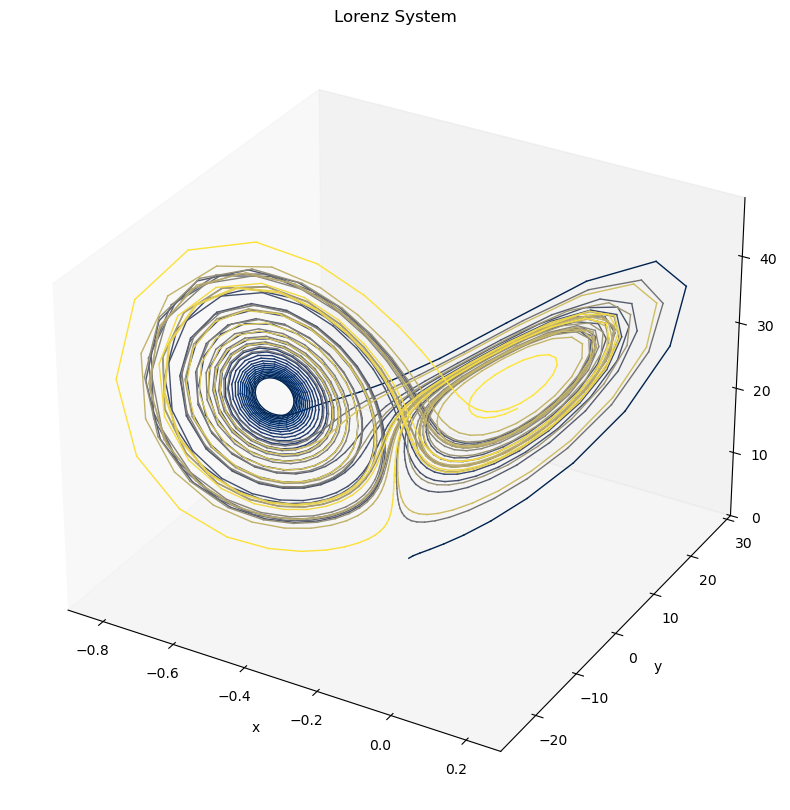

In [169]:
timesteps = 2000
fig = plt.figure(figsize=(10, 10))
ax  = fig.add_subplot(111, projection='3d')
ax.set_title("Lorenz System")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.grid(False)

for i in range(timesteps-1):
    ax.plot(X_norm_final[i:i+2, 0], X[i:i+2, 1], X[i:i+2, 2], color=plt.cm.cividis(255*i//timesteps), lw=1.0)
plt.show()

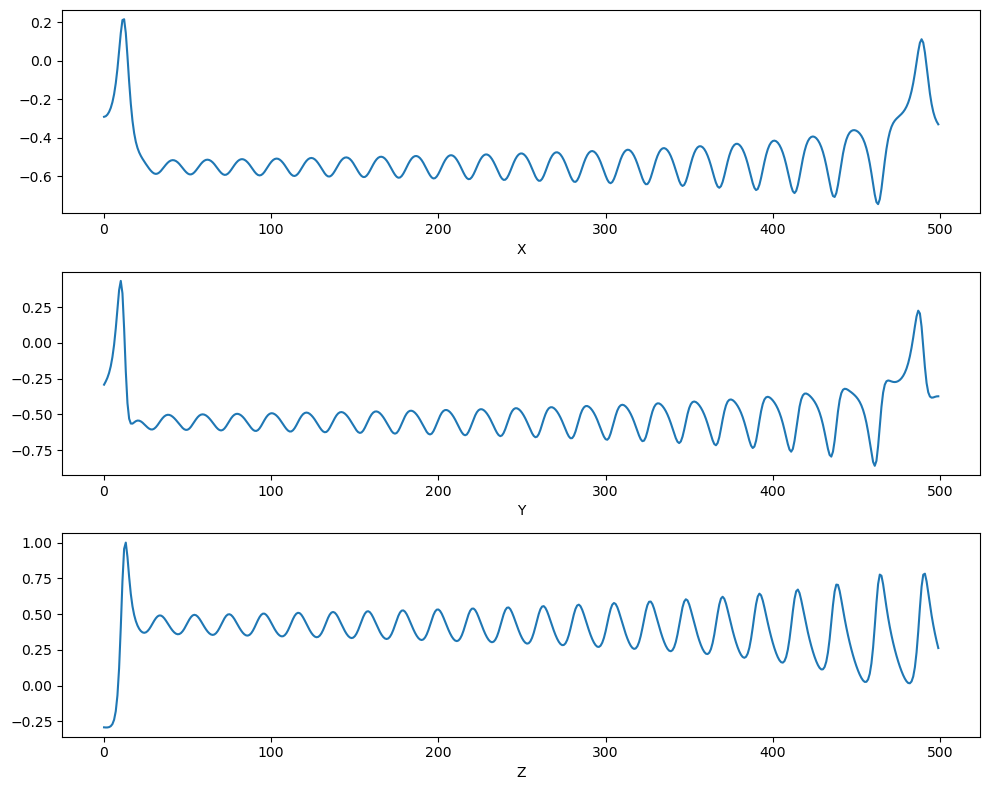

In [170]:
fig, axes = plt.subplots(3,1, figsize=(10, 8))

axes[0].plot(X_norm_final[:500, 0])
axes[1].plot(X_norm_final[:500, 1])
axes[2].plot(X_norm_final[:500, 2])

axes[0].set_xlabel("X")
axes[1].set_xlabel("Y")
axes[2].set_xlabel("Z")

plt.tight_layout()
plt.show()

In [171]:
reservoir1 = nodes.Reservoir(500, sr=1, seed=42, name="res1-1")
reservoir2 = nodes.Reservoir(500, sr=1, seed=42, name="res1-2")
reservoir3 = nodes.Reservoir(500, sr=1, seed=42, name="res1-3")
reservoir4 = nodes.Reservoir(500, sr=1, seed=42, name="res1-4")
reservoir5 = nodes.Reservoir(500, sr=1, seed=42, name="res1-5")

readout1 = nodes.Ridge(ridge=0.7, name="readout1-1")
readout2 = nodes.Ridge(ridge=0.7, name="readout1-2")
readout3 = nodes.Ridge(ridge=0.7, name="readout1-3")

data = nodes.Input()

reservoir = reservoir1 >> reservoir2 >> reservoir3 >> reservoir4 >> reservoir5 

model = data >> reservoir >> [readout1, readout2, readout3]

In [172]:
X_train = X_norm_final[:1500, :]
Y_train = X_norm_final[1:1501, :]

In [173]:
model.fit(
    X_train, 
    {
        "readout1-1": Y_train[:,0][:, np.newaxis],
        "readout1-2": Y_train[:,1][:, np.newaxis],
        "readout1-3": Y_train[:,2][:, np.newaxis]
    }
)

Model(Input(), Reservoir(units:500, input_dim:3, name:res1-1), Reservoir(units:500, input_dim:500, name:res1-2), Reservoir(units:500, input_dim:500, name:res1-3), Reservoir(units:500, input_dim:500, name:res1-4), Reservoir(units:500, input_dim:500, name:res1-5), Ridge(ridge:0.7, input_dim:500, output_dim:1, name:readout1-1), Ridge(ridge:0.7, input_dim:500, output_dim:1, name:readout1-2), Ridge(ridge:0.7, input_dim:500, output_dim:1, name:readout1-3))

In [174]:
state1 = reservoir1.state['out']
state2 = reservoir2.state['out']
state3 = reservoir3.state['out']

In [175]:
Y_pred = model.run(X_norm_final[1500:])

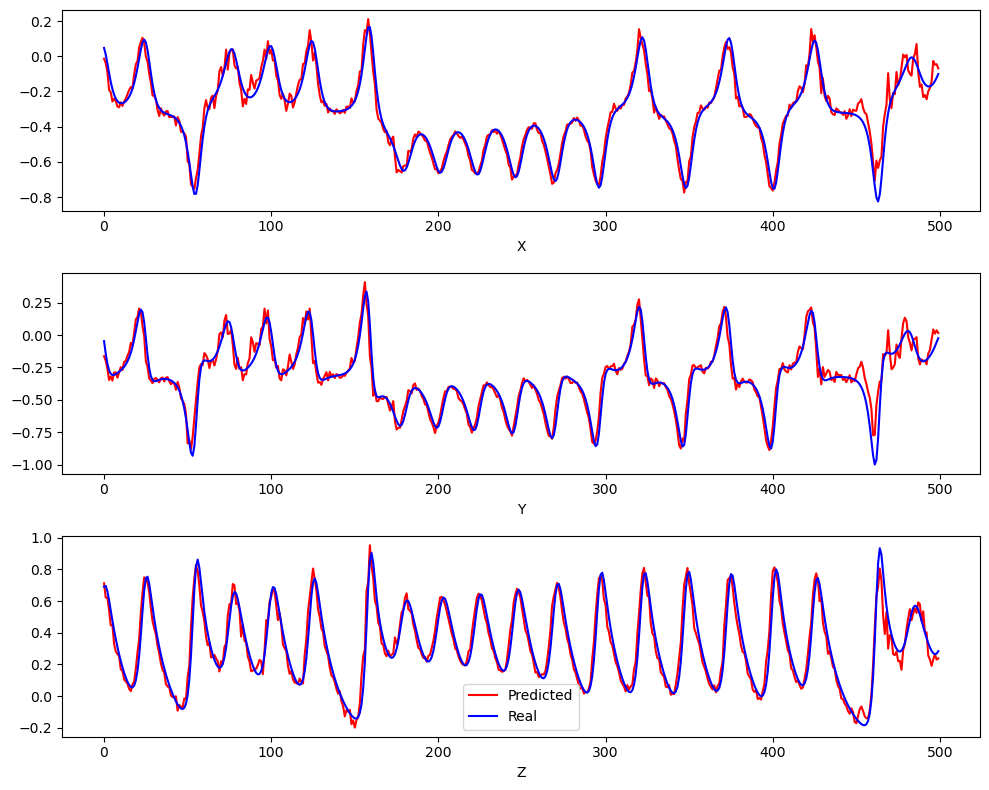

In [176]:
fig, axes = plt.subplots(3,1, figsize=(10, 8))

axes[0].plot(Y_pred['readout1-1'], label = "Predicted", color="red")
axes[1].plot(Y_pred['readout1-2'], label = "Predicted", color="red")
axes[2].plot(Y_pred['readout1-3'], label = "Predicted", color="red")
axes[0].plot(X_norm_final[1500:, 0], label = "Real", color="blue")
axes[1].plot(X_norm_final[1500:, 1], label = "Real", color="blue")
axes[2].plot(X_norm_final[1500:, 2], label = "Real", color="blue")

axes[0].set_xlabel("X")
axes[1].set_xlabel("Y")
axes[2].set_xlabel("Z")

plt.legend()
plt.tight_layout()
plt.show()

In [177]:
param_grid = {
    'input_scaling': [0.1, 0.5, 0.9],
    'N': [100, 200, 300],  # Number of reservoir units
    'sr': [0.5, 0.9, 1.2],  # Spectral radius
    'lr': [0.1, 0.3, 0.5],  # Leaking rate
    'ridge': [1e-8, 1e-6, 1e-4]
}

In [178]:
from reservoirpy.observables import nrmse

def objective_function(dataset, config, *, input_scaling, N, sr, lr, ridge, seed):
    x_train, x_test, y_train, y_test = dataset
    
    reservoir1 = nodes.Reservoir(units=N, sr=sr, lr=lr, input_scaling=input_scaling, seed=42, name="res1-1")
    reservoir2 = nodes.Reservoir(units=N, sr=sr, lr=lr, input_scaling=input_scaling, seed=42, name="res1-2")
    reservoir3 = nodes.Reservoir(units=N, sr=sr, lr=lr, input_scaling=input_scaling, seed=42, name="res1-3")
    reservoir4 = nodes.Reservoir(units=N, sr=sr, lr=lr, input_scaling=input_scaling, seed=42, name="res1-4")
    reservoir5 = nodes.Reservoir(units=N, sr=sr, lr=lr, input_scaling=input_scaling, seed=42, name="res1-5")
    
    readout1 = nodes.Ridge(ridge=ridge, name="readout1-1")
    readout2 = nodes.Ridge(ridge=ridge, name="readout1-2")
    readout3 = nodes.Ridge(ridge=ridge, name="readout1-3")
    
    data = nodes.Input()
    
    reservoir = reservoir1 >> reservoir2 >> reservoir3 >> reservoir4 >> reservoir5 
    
    model = data >> reservoir >> [readout1, readout2, readout3]

    # Train and test the model
    model.fit(
        X_train, 
        {
            "readout1-1": Y_train[:,0][:, np.newaxis],
            "readout1-2": Y_train[:,1][:, np.newaxis],
            "readout1-3": Y_train[:,2][:, np.newaxis]
        }
    )
    y_pred = model.run(x_test)

    lossx = nrmse(y_test[:,0][:, np.newaxis], y_pred['readout1-1']) # Or any other desired metric
    lossy = nrmse(y_test[:,1][:, np.newaxis], y_pred['readout1-2']) # Or any other desired metric
    lossz = nrmse(y_test[:,2][:, np.newaxis], y_pred['readout1-3']) # Or any other desired metric
    
    return {'loss': np.mean((lossx, lossy, lossz))}

In [179]:
# import itertools

# best_loss = float('inf')
# best_params = None

# # Assuming 'data' is your preprocessed dataset and 'config' contains other settings
# # like instances_per_trial for averaging over multiple runs with different seeds.
# # For simplicity, we're omitting 'config' and 'instances_per_trial' here.

# X_train = X_norm_final[:1500, :]
# Y_train = X_norm_final[1:1501, :]
# X_test = X_norm_final[1500:,:]
# Y_test = X_norm_final[1500:,:]

# data = (X_train, X_test, Y_train, Y_test)
# for params_tuple in itertools.product(*param_grid.values()):
#     current_params = dict(zip(param_grid.keys(), params_tuple))
    
#     # Call your objective function with the current set of hyperparameters
#     # You would typically pass your training/testing data and a seed here
#     # For this example, let's assume 'data' and a fixed 'seed'
#     result = objective_function(dataset=data, config={}, seed=42, **current_params) 
    
#     if result['loss'] < best_loss:
#         best_loss = result['loss']
#         best_params = current_params
# print(f"Best hyperparameters: {best_params}")
# print(f"Best loss: {best_loss}")

KeyboardInterrupt: 

In [180]:
reservoir1 = nodes.Reservoir(units=200, input_scaling=0.1, lr=0.5, sr=0.5, seed=42, name="res1-1")
reservoir2 = nodes.Reservoir(units=200, input_scaling=0.1, lr=0.5, sr=0.5, seed=42, name="res1-2")
reservoir3 = nodes.Reservoir(units=200, input_scaling=0.1, lr=0.5, sr=0.5, seed=42, name="res1-3")
reservoir4 = nodes.Reservoir(units=200, input_scaling=0.1, lr=0.5, sr=0.5, seed=42, name="res1-4")
reservoir5 = nodes.Reservoir(units=200, input_scaling=0.1, lr=0.5, sr=0.5, seed=42, name="res1-5")

readout1 = nodes.Ridge(ridge=1e-08, name="readout1-1")
readout2 = nodes.Ridge(ridge=1e-08, name="readout1-2")
readout3 = nodes.Ridge(ridge=1e-08, name="readout1-3")

data = nodes.Input()

reservoir = reservoir1 >> reservoir2 >> reservoir3 >> reservoir4 >> reservoir5 
model = data >> reservoir >> [readout1, readout2, readout3]

In [181]:
model.fit(
    X_train, 
    {
        "readout1-1": Y_train[:,0][:, np.newaxis],
        "readout1-2": Y_train[:,1][:, np.newaxis],
        "readout1-3": Y_train[:,2][:, np.newaxis]
    }
)

Model(Input(), Reservoir(units:200, lr:0.5, sr:0.5, input_scaling:0.1, input_dim:3, name:res1-1), Reservoir(units:200, lr:0.5, sr:0.5, input_scaling:0.1, input_dim:200, name:res1-2), Reservoir(units:200, lr:0.5, sr:0.5, input_scaling:0.1, input_dim:200, name:res1-3), Reservoir(units:200, lr:0.5, sr:0.5, input_scaling:0.1, input_dim:200, name:res1-4), Reservoir(units:200, lr:0.5, sr:0.5, input_scaling:0.1, input_dim:200, name:res1-5), Ridge(ridge:1e-08, input_dim:200, output_dim:1, name:readout1-1), Ridge(ridge:1e-08, input_dim:200, output_dim:1, name:readout1-2), Ridge(ridge:1e-08, input_dim:200, output_dim:1, name:readout1-3))

In [ ]:
# Y_pred = model.run(X_norm_final[1500:])

In [ ]:
# fig, axes = plt.subplots(3,1, figsize=(10, 8))

# axes[0].plot(Y_pred['readout1-1'], label = "Predicted", color="red")
# axes[1].plot(Y_pred['readout1-2'], label = "Predicted", color="red")
# axes[2].plot(Y_pred['readout1-3'], label = "Predicted", color="red")
# axes[0].plot(X_norm_final[1500:, 0], label = "Real", color="blue")
# axes[1].plot(X_norm_final[1500:, 1], label = "Real", color="blue")
# axes[2].plot(X_norm_final[1500:, 2], label = "Real", color="blue")

# axes[0].set_xlabel("X")
# axes[1].set_xlabel("Y")
# axes[2].set_xlabel("Z")

# plt.legend()
# plt.tight_layout()
# plt.show()

In [182]:
Y_pred_5 = np.empty((3, 5))
x = Y_train[-1].copy().reshape(1,3)
STATE_pred_5 = np.empty((5, 5, 200))
for i in range(5):
    # print(x)
    output = model.run(x)
    STATE_pred_5[0, i] = reservoir1.state['out']
    STATE_pred_5[1, i] = reservoir2.state['out']
    STATE_pred_5[2, i] = reservoir3.state['out']
    STATE_pred_5[3, i] = reservoir4.state['out']
    STATE_pred_5[4, i] = reservoir5.state['out']
    

    Y_pred_5[0,i] = output['readout1-1'].squeeze()
    Y_pred_5[1,i] = output['readout1-2'].squeeze()
    Y_pred_5[2,i] = output['readout1-3'].squeeze()
    
    x = Y_pred_5[:,i].reshape(1,3)
# Y_pred_5

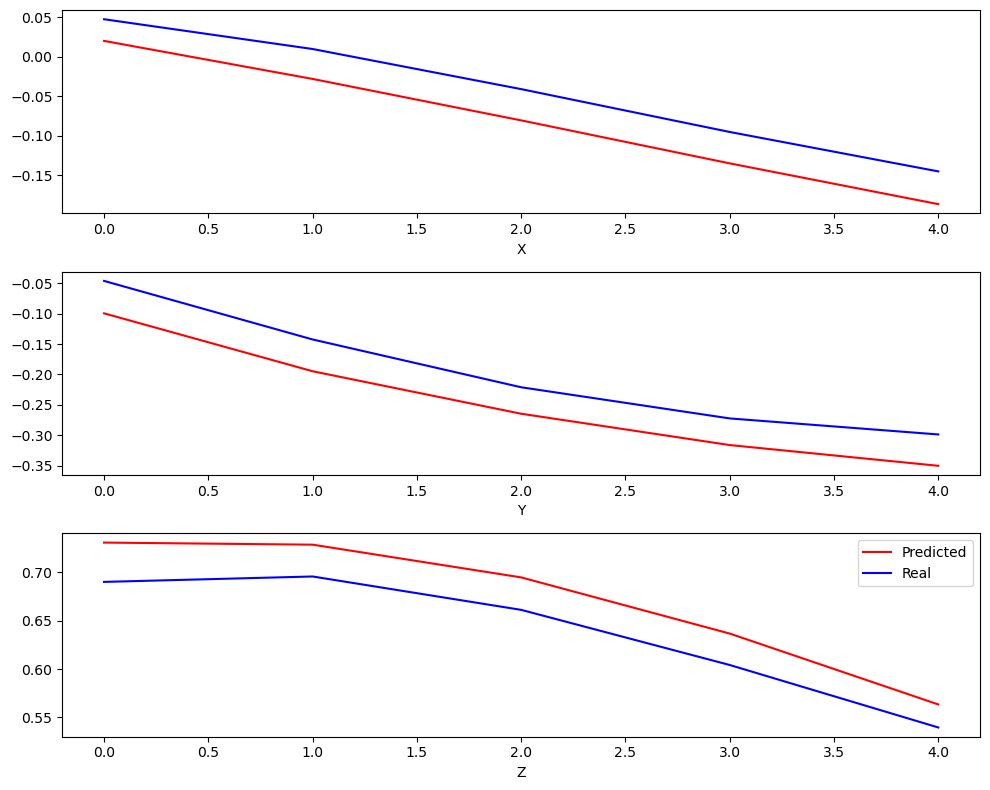

In [183]:
fig, axes = plt.subplots(3,1, figsize=(10, 8))

axes[0].plot(Y_pred_5[0,:], label = "Predicted", color="red")
axes[1].plot(Y_pred_5[1,:], label = "Predicted", color="red")
axes[2].plot(Y_pred_5[2,:], label = "Predicted", color="red")
axes[0].plot(X_norm_final[1500:1505, 0], label = "Real", color="blue")
axes[1].plot(X_norm_final[1500:1505, 1], label = "Real", color="blue")
axes[2].plot(X_norm_final[1500:1505, 2], label = "Real", color="blue")

axes[0].set_xlabel("X")
axes[1].set_xlabel("Y")
axes[2].set_xlabel("Z")

plt.legend()
plt.tight_layout()
plt.show()

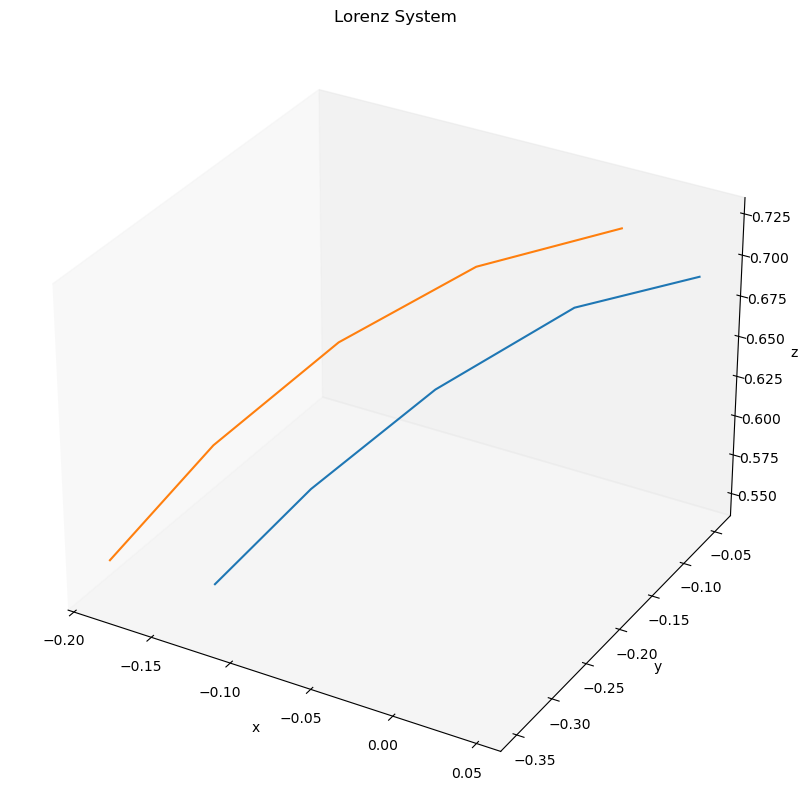

In [184]:
timesteps = 2000
fig = plt.figure(figsize=(10, 10))
ax  = fig.add_subplot(111, projection='3d')
ax.set_title("Lorenz System")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.grid(False)

ax.plot(X_norm_final[1500:1505, 0], X_norm_final[1500:1505, 1], X_norm_final[1500:1505, 2])
ax.plot(Y_pred_5[0,:], Y_pred_5[1,:], Y_pred_5[2,:])

plt.show()

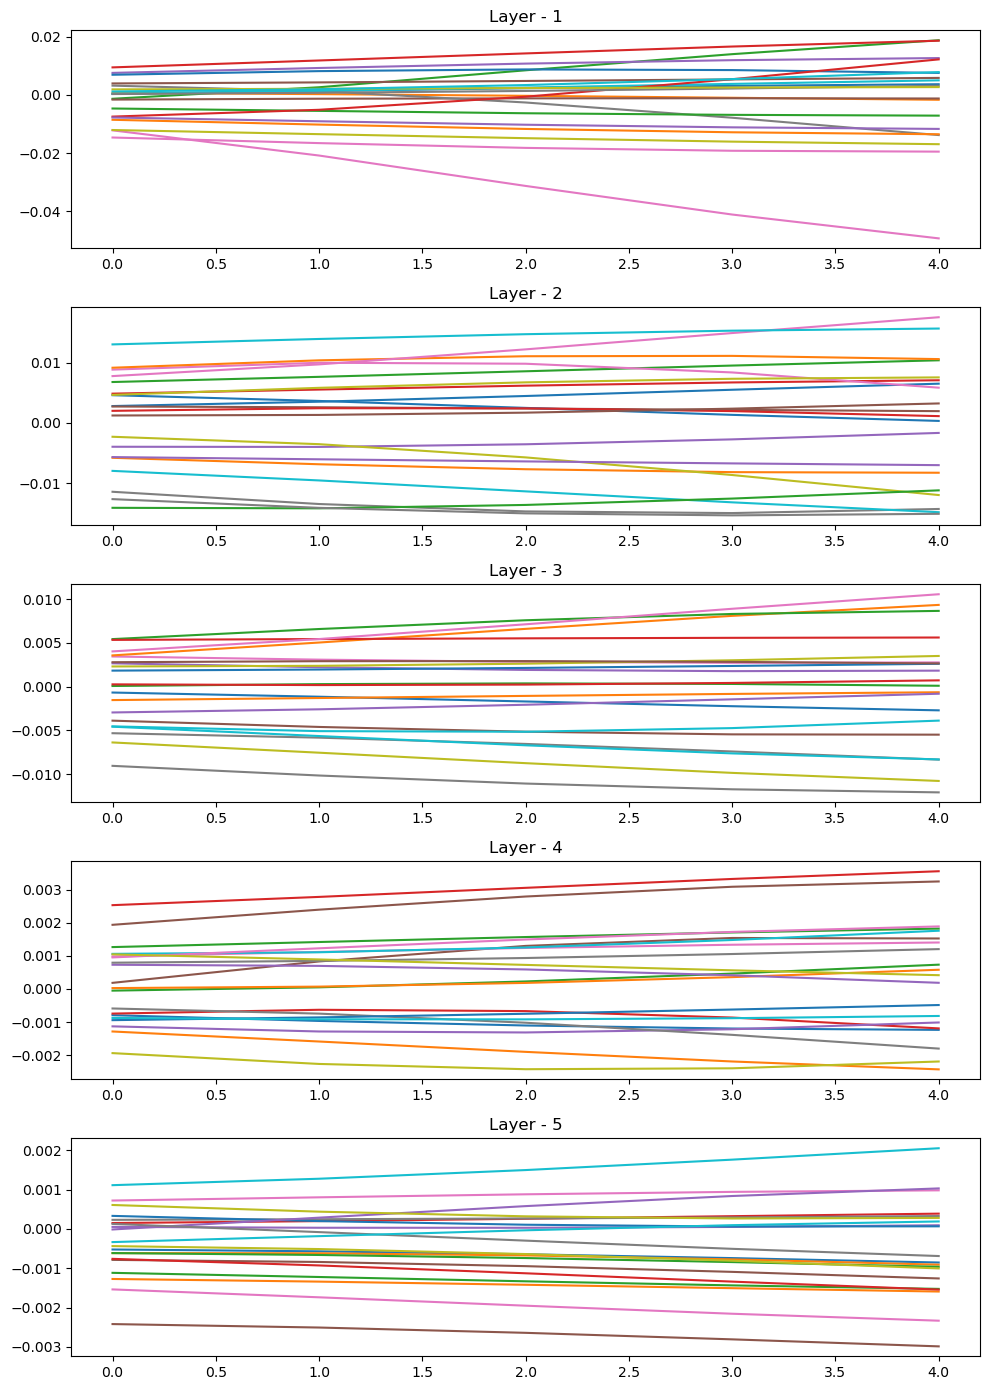

In [185]:
fig, axes = plt.subplots(5,1, figsize=(10, 14))

for i in range(5):
    axes[i].plot(STATE_pred_5[i, :, :20])
    axes[i].set_title(f"Layer - {i+1}")


# plt.legend()
plt.tight_layout()
plt.show()

In [196]:
np.sqrt((np.sum(Y_pred_5.T - X_norm_final[1500:1505, :])**2)/5)

np.float64(0.11941333925630516)

In [197]:
# len(Y_pred_5)